### Описание

На выполнение задания ушло ~25ч., включая правку багов и вхождение в материал обработки больших объемов данных.
***
Исходный датасет был взят с Kaggle - 100 Million+ Steam Reviews (https://www.kaggle.com/datasets/kieranpoc/steam-reviews?select=weighted_score_above_08.csv). 

Датасет предоставлял данные об отзывах пользователей к играм Steam.

Из данного датасета были взяты колонки: 
***
['recommendationid', 'game', 'timestamp_created', 'author_playtime_forever']

['Id отзыва', 'Название игры', 'Дата создания отзыва', 'Абсолютное игры пользователя в минутах']
***

### Код задания

In [57]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt 
from multiprocessing import Pool
import csv
import numpy as np
from scipy import stats
from scipy.stats import sem
import seaborn as sns

### Считывание и процессинг

Парсинг основного csv со 100млн+ отзывов на игры Steam в отдельный файл (reviews.csv) для удобства

In [ ]:

input_file = 'all_reviews.csv'
output_file = "reviews.csv"
columns = ['recommendationid', 'game', 'timestamp_created', 'author_playtime_forever']

dtypes = {
    'recommendationid': 'int',
    'game': 'object',
    'timestamp_created': 'object',
    'author_playtime_forever': 'object'
}

def fill_csv():
    """Парсинг указанных columns в отдельный csv"""
    
    row_counter = 0
    df_chunked = pd.read_csv(input_file, usecols=columns, dtype=dtypes, on_bad_lines='skip', chunksize=1000000)
    with open(output_file, 'a', encoding="utf-8", newline='') as f:
        while row_counter < 80000000:
            for chunk in df_chunked:
                chunk.dropna()
                chunk.to_csv(f, index=False, header=False)
                row_counter += 1000000
                print(f"{row_counter} ROWS READY!")

def fill_duplicates():
    """Добавление дубликатов"""

    row_counter = 0
    duplicate_row = pd.read_csv(input_file, nrows=1000)
    with open(output_file, 'a', encoding="utf-8", newline='') as f:
        while row_counter < 30000000:
            duplicate_row.to_csv(f, index=False, header=False)
            row_counter += 1000
            print(f"{row_counter} ROWS READY!")


### Расчет метрик

Cоздание очищенного csv после парсинга (clear_reviews.csv), удаление дубликатов, NaN а также значений в диапазоне 01:00 до 03:00 часов ночи

In [ ]:
from_df = "reviews.csv"
to_df = 'clear_reviews.csv'
columns = ['recommendationid', 'game', 'author_playtime_forever', 'timestamp_created']

dtypes = {
    'recommendationid': 'int',
    'game': 'object',
    'timestamp_created': 'object',
    'author_playtime_forever': 'object'
}

df_chunked = pd.read_csv(from_df, names=columns, dtype=dtypes, chunksize=1000000)

def get_info(df):
    """Вывод информации о df для тестов"""

    na_vals = df.isna().sum().sum()
    rows = df.shape[0]
    
    dup_raw = df.duplicated(keep=False).sum()
    dup_per = round((dup_raw*100)/df.shape[0],2)

    print(f"       Количество строк: {rows}")
    print(f"              Дубликаты: {dup_raw} | {dup_per}%")
    print(f"Количество NaN значений: {na_vals}")
    print("-"*25)
    print(display(df.head(10)))


def clearing():
    """Очистка csv от дубликатов, NaN и записей между 01:00 и 03:00"""

    counter = 0
    with open(to_df, 'a', encoding="utf-8", newline='') as f:
        for chunk in df_chunked:
            df = chunk.drop_duplicates().dropna()
            df['timestamp_created'] = dd.to_datetime(df['timestamp_created'], unit='s', errors='coerce').astype({'timestamp_created': 'object'})
            start_time = pd.to_datetime('01:00:00', format='%H:%M:%S').time()
            end_time = pd.to_datetime('03:00:00', format='%H:%M:%S').time()
            time = df['timestamp_created'].astype('datetime64[ms]').dt.time
            clear_df = df[~time.between(start_time, end_time)]
                
            clear_df.to_csv(f, index=False, header=False)
            counter += 1000000
            print(f"{counter} GOT!")

После всех обработок на выходе имеется чистый файл - clear_reviews.csv объемом на 4.5гб (исходный файл reviews.csv был на 43гб).

### Расчет метрик и мерж

Функция set_metrics создает отдельный файл (metrics.csv) с метриками очищенного csv (clear_reviews.csv)

Функция merge_metrics выполняет мерж clear_reviews.csv с метриками metrics.csv относительно близжайшего часа (для удобства создается отдельный файл)

In [ ]:
csv_file = 'clear_reviews.csv'
columns = ['recommendationid', 'game', 'author_playtime_forever', 'timestamp_created']

dtypes = {
    'recommendationid': 'int',
    'game': 'object',
    'timestamp_created': 'object',
    'author_playtime_forever': 'int'
}

df = pd.read_csv(csv_file, names=columns, dtype=dtypes, on_bad_lines='skip', chunksize=1000000) 

def set_metrics(df):
    """Создание файла с метриками для очищенного csv"""

    for chunk in df:
        chunk['timestamp_created'] = pd.to_datetime(chunk['timestamp_created'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
        chunk['hour'] = chunk['timestamp_created'].apply(lambda x: f"{x.hour}-{x.hour+1}")
        out = chunk.groupby(chunk['hour']).agg(median=('author_playtime_forever', 'median'), mean=('author_playtime_forever', 'mean'), unique_vals=('recommendationid', 'count')).round().reset_index()
        out.to_csv('metrics.csv', index=False, header=False)

def merge_metrics(df, df_metrics):
    """Мерж очищенного csv с метриками из файла metrics.csv"""

    counter = 0
    with open('reviews_with_metrics.csv', 'a', encoding="utf-8", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['recommendationid', 'game', 'author_playtime_forever', 'timestamp_created', 'median', 'mean', 'unique_vals'])
        for chunk in df:
            chunk['timestamp_created'] = pd.to_datetime(chunk['timestamp_created'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
            chunk['hour'] = chunk['timestamp_created'].apply(lambda x: f"{x.hour}-{x.hour+1}")
            chunk = chunk.merge(df_metrics[['hour', 'median', 'mean', 'unique_vals']], on='hour', how='inner').drop('hour', axis=1)
            chunk.to_csv(f, index=False, header=False)
            counter += 1000000
            print(f"{counter} GOT!")


### SQL код для решение подобной задачи в PostgreSQL

with t1 as (

select (to_char(date, 'HH24')::int+1) as hour_, PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY time) as median, avg(time) as avg_time, count(distinct g.game) as unique_vals
  
  from games as g
 
 group by to_char(date, 'HH24')::int

)
 
select id, game, time, date, t1.median, t1.avg_time, t1.unique_vals 
  
  from games as g 
 
 inner join t1 on t1.hour_ = (to_char(g.date, 'HH24')::int+1)

### Аналитические метрики

1. Построение гистограммы относительно количества игроков и времени проведенного в игре

In [ ]:
csv_file = 'reviews_with_metrics.csv'
df = pd.read_csv(csv_file,usecols=['author_playtime_forever'])

In [ ]:
for i, settings in enumerate([[100000, 4000000, 1500000], [10000, 400000, 2000000]]):
    print(f"Settings: {settings}")
    plt.hist(df['author_playtime_forever'], bins=int(6007985/settings[0]), color = 'blue', edgecolor = 'black')
    plt.xlim(0,settings[1])
    plt.ylim(0,settings[2])
    plt.title('Время в игре. Распределение по количеству пользователей.')
    plt.ylabel('Количество игроков')
    plt.xlabel('Время в игре (author_playtime_forever, минуты)')

    plt.show() 

Ниже показаны гистограммы разного масштаба для наглядности, т.к. большинство игроков не имеют более 30 000 часов в играх

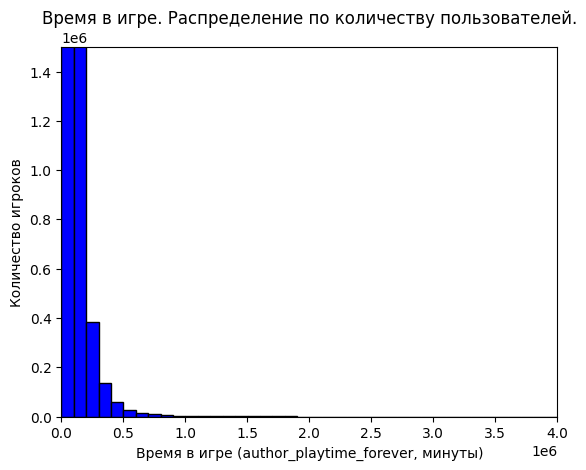  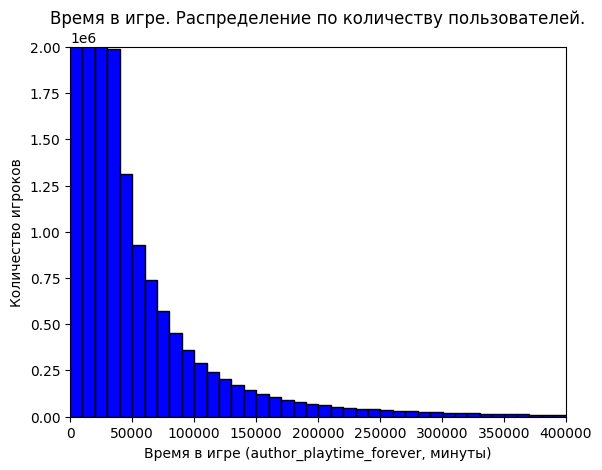

2. Расчет 95% доверительного интервала

В данном случае выделяют 2 подхода:
> t-распределение: менее 30 элементов

> z-распределение: более 30 элементов

Таким образом выбирается подход через z-распределение, т.к. элементов больше 30.

In [ ]:
csv_file = 'reviews_with_metrics.csv'

df = pd.read_csv(csv_file,usecols=['author_playtime_forever'])

mean_val = df['author_playtime_forever'].mean()
std_val = df['author_playtime_forever'].std()
n = len(df)

confidence_level = 0.95
alpha = 1 - confidence_level
z_critical = stats.norm.ppf(1 - alpha / 2)

margin_of_error = z_critical * (std_val / np.sqrt(n))

confidence_interval = (mean_val - margin_of_error, mean_val + margin_of_error)

In [ ]:
# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.hist(df['author_playtime_forever'], bins=10)
plt.xlim(12650,12750)
plt.ylim(0,100000)
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label='Среднее значение')
plt.axvline(confidence_interval[0], color='blue', linestyle='dashed', linewidth=2, label='Наименьшее значение интервала')
plt.axvline(confidence_interval[1], color='pink', linestyle='dashed', linewidth=2, label='Наибольшее значение интервала')

plt.title('Доверительный интервал 95%')
plt.xlabel('Время в игре')
plt.ylabel('Количество игроков')
plt.legend()
plt.grid()

plt.show()

Ниже представленна диаграмма доверительного интервала

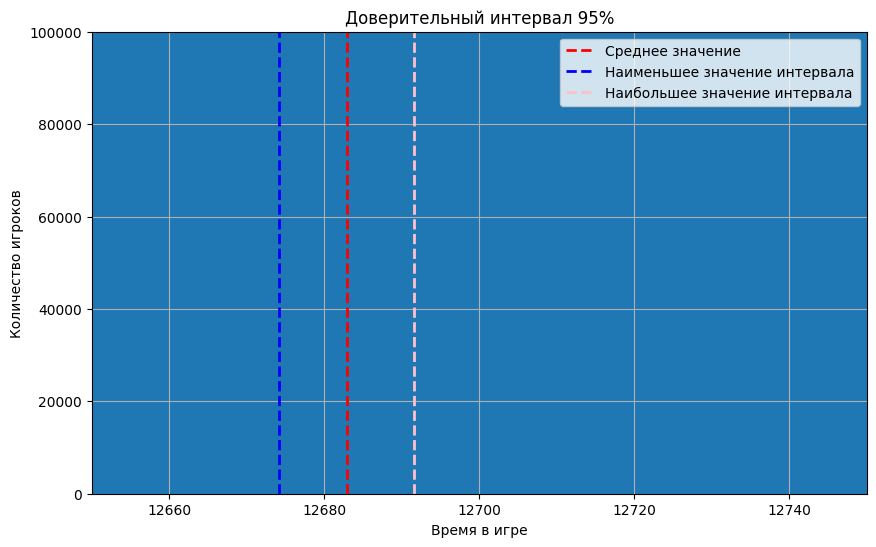

### Визуализация

1. График среднего значения numeric колонки (y) по месяцам (x).

В данном случае, также для удобства, создается отдельный csv с метриками среднего игрового времени для каждого месяца. 

In [37]:
csv_file = 'clear_reviews.csv'
columns = ['recommendationid', 'game', 'author_playtime_forever', 'timestamp_created']

dtypes = {
    'recommendationid': 'int',
    'game': 'object',
    'timestamp_created': 'object',
    'author_playtime_forever': 'int'
}

df = pd.read_csv(csv_file, names=columns, dtype=dtypes, on_bad_lines='skip', chunksize=1000000) 

def set_metrics(df):
    """Создание файла с метриками для каждого месяца"""

    for chunk in df:
        chunk['timestamp_created'] = pd.to_datetime(chunk['timestamp_created'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
        chunk['hour'] = chunk['timestamp_created'].apply(lambda x: f"{x.month}")
        out = chunk.groupby(chunk['hour']).agg(mean=('author_playtime_forever', 'mean')).round().reset_index()
        out.to_csv('metrics_month.csv', index=False, header=False)


In [ ]:
csv_file = 'metrics_month.csv'
df = pd.read_csv(csv_file, usecols=['month', 'mean'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(df['month'], df['mean']/60, color = 'blue', edgecolor = 'black', width=0.5)
ax.set_title('Среднее время в игре по месяцам')
ax.set_ylabel('Время, ч.')

plt.show() 

Результат отрисовки диаграммы со средним значением времени в игре по месяцам

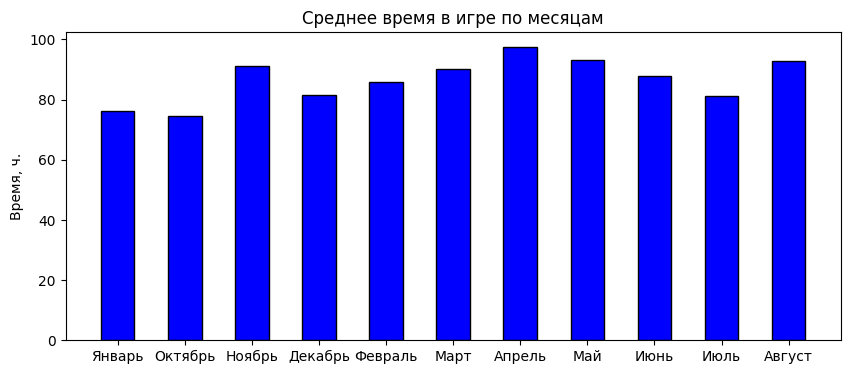

2. Heatmap по частотности символов в колонке string.

В данном случае решил не брать абсолютно все символы названия игр, т.к. названия содержат не толькко английский алфавит.

Для удобства создается отдельный csv с даннми о количестве игр в clear_reviews.csv, чтобы быстрее считать количество символов.

In [74]:
csv_file = 'clear_reviews.csv'
columns = ['recommendationid', 'game', 'author_playtime_forever', 'timestamp_created']

dtypes = {
    'recommendationid': 'int',
    'game': 'object',
    'timestamp_created': 'object',
    'author_playtime_forever': 'int'
}

df = pd.read_csv(csv_file, names=columns, dtype=dtypes, on_bad_lines='skip', chunksize=1000000) 

def set_metrics(df):
    """Создание файла с метриками по количеству одинаковых игр в отзывах"""

    for chunk in df:
        out = chunk.groupby(chunk['game']).agg(count=('game', 'count')).round().reset_index()
        out.to_csv('metrics_games.csv', index=False)


Псоле чего проводится подсчет всех символов, которые совпадают с символами в массиве characters.

In [ ]:
csv_file = 'metrics_games.csv'
dtypes = {
    'game': 'object',
    'count': 'int'
}

characters = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
]

df = pd.read_csv(csv_file,usecols=['game', 'count'], dtype=dtypes)


all_chars = ''.join(characters)
char_freq = pd.Series(list(all_chars)).value_counts()

char_matrix = pd.DataFrame(0, index=char_freq.index, columns=char_freq.index)

for index, row in df.iterrows():
    for char in row['game']:
        if char in characters:
            char_matrix[char][char] += row['count']

In [ ]:
plt.figure(figsize=(100, 100))
sns.heatmap(char_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Частотность символов')
plt.xlabel('Символы')
plt.ylabel('Символы')
plt.show()

Результат отрисовки диаграммы по количеству символов в строках игр

